In [1]:
import sys
sys.path.append(os.path.join(".."))
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report

In [2]:
train_data_dir = "../data/impressionist_images/training/training/"
val_data_dir = "../data/impressionist_images/validation/validation/"

train_data_dir = Path(train_data_dir)
val_data_dir = Path(val_data_dir)

In [3]:
train_image_count = len(list(train_data_dir.glob('**/*.jpg')))
val_image_count = len(list(val_data_dir.glob('**/*.jpg')))

print(train_image_count)
print(val_image_count)

3988
990


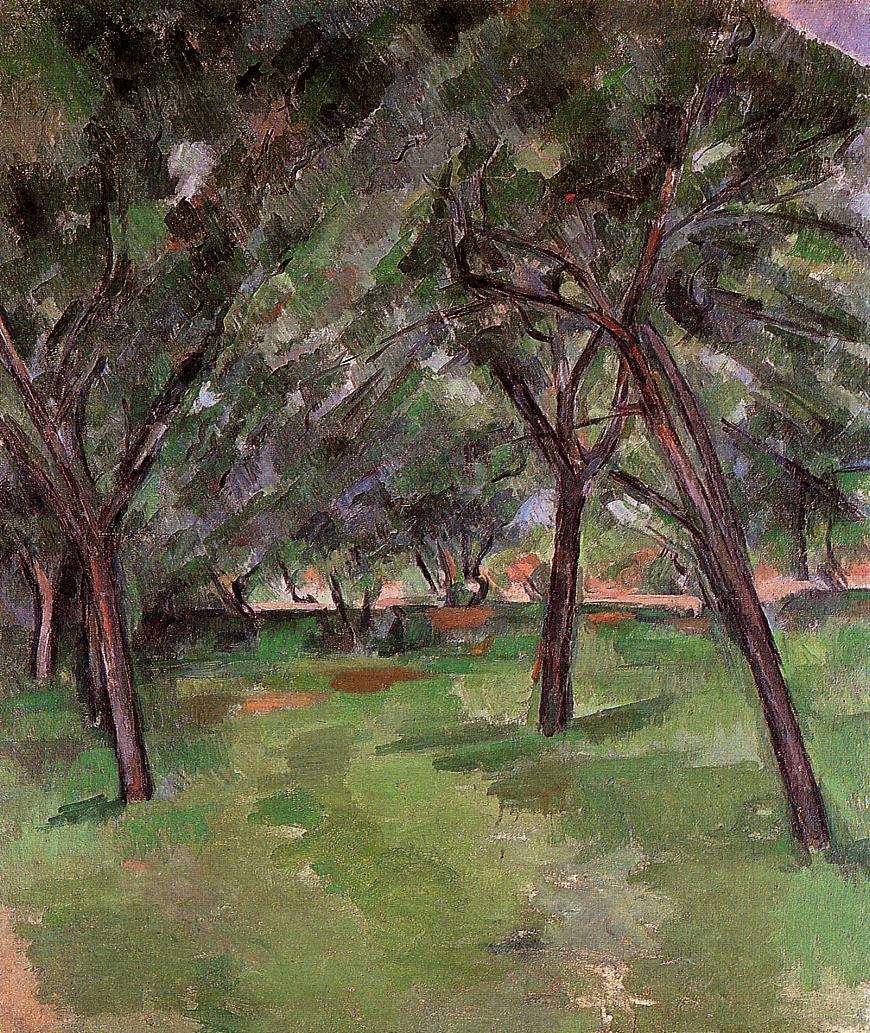

In [4]:
Cezanne = list(train_data_dir.glob('**/Cezanne/*'))
PIL.Image.open(str(Cezanne[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=69,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3988 files belonging to 10 classes.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_data_dir,
  seed=69,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 990 files belonging to 10 classes.


In [8]:
train_class_names = train_ds.class_names
val_class_names = val_ds.class_names

In [9]:
val_images = np.concatenate([x for x, y in val_ds], axis=0)
val_images[0]

array([[[ 49.00324 ,  59.010185,  47.963425],
        [139.65138 , 144.2625  , 124.35694 ],
        [ 89.60649 , 100.78474 ,  83.31714 ],
        ...,
        [195.95512 , 167.16599 ,  91.33009 ],
        [149.62903 , 143.96211 ,  80.375725],
        [157.29736 , 172.30304 , 170.97238 ]],

       [[ 18.997215,  29.997215,  22.830547],
        [ 64.71251 ,  74.78334 ,  64.50835 ],
        [ 95.951385, 110.201385, 100.24999 ],
        ...,
        [170.38826 , 141.87411 ,  42.53416 ],
        [161.27118 , 146.89188 ,  68.44578 ],
        [151.62346 , 156.91359 ,  77.68031 ]],

       [[ 33.0588  ,  45.03102 ,  45.086575],
        [ 56.652775,  72.629166,  72.65972 ],
        [ 35.782413,  55.782413,  44.782413],
        ...,
        [197.9789  , 169.43742 ,  51.708073],
        [154.52148 , 138.406   ,  42.673862],
        [ 97.90276 ,  94.00143 ,  29.923016]],

       ...,

       [[108.730644,  93.730644,  86.84173 ],
        [123.552734, 104.44858 ,  97.4069  ],
        [113.16427 ,  

In [10]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_labels[0:10]

array([1, 5, 8, 0, 2, 8, 2, 6, 4, 7])

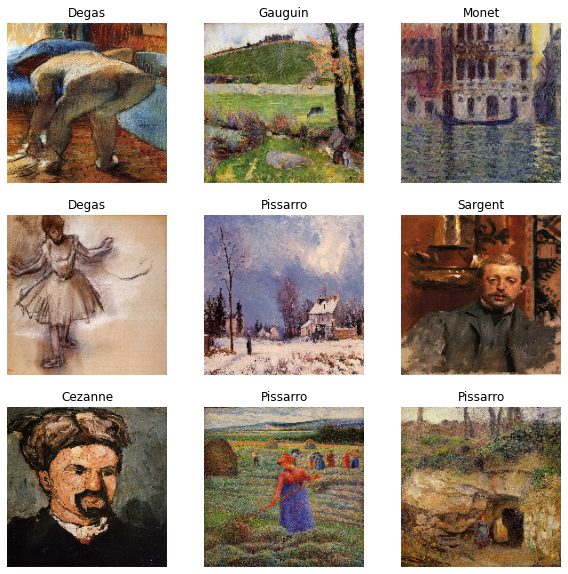

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0063730283 1.0


In [16]:
num_classes = 10

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [19]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
125/125 [==============================] - 40s 321ms/step - loss: 2.2162 - accuracy: 0.1763 - val_loss: 1.9581 - val_accuracy: 0.3313
Epoch 2/10
125/125 [==============================] - 33s 263ms/step - loss: 1.8128 - accuracy: 0.3720 - val_loss: 1.8506 - val_accuracy: 0.3747
Epoch 3/10
125/125 [==============================] - 35s 283ms/step - loss: 1.4750 - accuracy: 0.4854 - val_loss: 1.8447 - val_accuracy: 0.3879
Epoch 4/10
125/125 [==============================] - 35s 280ms/step - loss: 1.0751 - accuracy: 0.6436 - val_loss: 2.0357 - val_accuracy: 0.3949
Epoch 5/10
125/125 [==============================] - 35s 278ms/step - loss: 0.6520 - accuracy: 0.7994 - val_loss: 2.5020 - val_accuracy: 0.3616
Epoch 6/10
125/125 [==============================] - 34s 276ms/step - loss: 0.3208 - accuracy: 0.9115 - val_loss: 2.8137 - val_accuracy: 0.3687
Epoch 7/10
125/125 [==============================] - 35s 277ms/step - loss: 0.1430 - accuracy: 0.9638 - val_loss: 3.6099 - val_ac

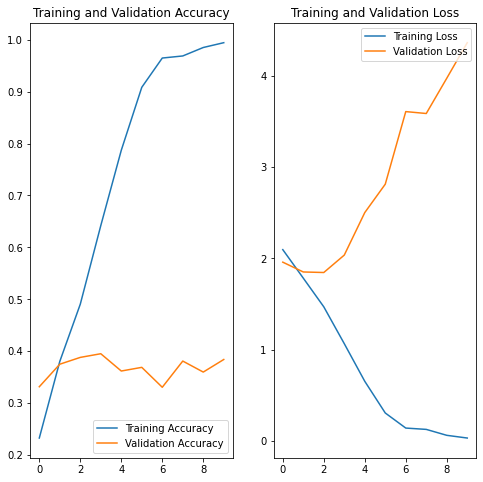

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
predictions = model.predict(val_images, batch_size=32)
print(classification_report(val_labels,
                            predictions.argmax(axis=1),
                            target_names=val_class_names))

              precision    recall  f1-score   support

     Cezanne       0.14      0.14      0.14        99
       Degas       0.13      0.09      0.11        99
     Gauguin       0.06      0.06      0.06        99
      Hassam       0.06      0.08      0.07        99
     Matisse       0.16      0.15      0.16        99
       Monet       0.09      0.09      0.09        99
    Pissarro       0.08      0.09      0.09        99
      Renoir       0.08      0.05      0.06        99
     Sargent       0.10      0.12      0.11        99
     VanGogh       0.11      0.13      0.12        99

    accuracy                           0.10       990
   macro avg       0.10      0.10      0.10       990
weighted avg       0.10      0.10      0.10       990



In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

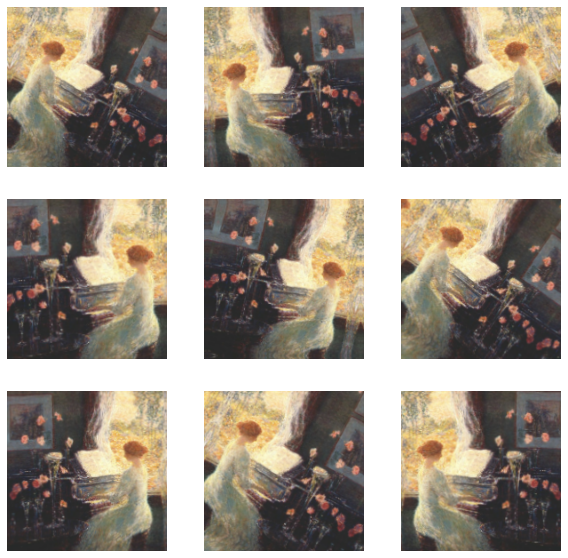

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
125/125 [==============================] - 38s 294ms/step - loss: 2.2941 - accuracy: 0.1602 - val_loss: 2.0988 - val_accuracy: 0.2414
Epoch 2/15
125/125 [==============================] - 36s 289ms/step - loss: 1.9829 - accuracy: 0.3071 - val_loss: 2.3297 - val_accuracy: 0.2525
Epoch 3/15
125/125 [==============================] - 36s 288ms/step - loss: 1.8936 - accuracy: 0.3448 - val_loss: 2.0821 - val_accuracy: 0.3232
Epoch 4/15
125/125 [==============================] - 36s 292ms/step - loss: 1.7483 - accuracy: 0.3932 - val_loss: 2.0440 - val_accuracy: 0.3253
Epoch 5/15
125/125 [==============================] - 36s 287ms/step - loss: 1.7046 - accuracy: 0.4131 - val_loss: 2.0431 - val_accuracy: 0.3253
Epoch 6/15
125/125 [==============================] - 37s 295ms/step - loss: 1.6406 - accuracy: 0.4353 - val_loss: 2.5222 - val_accuracy: 0.3000
Epoch 7/15
125/125 [==============================] - 36s 288ms/step - loss: 1.5830 - accuracy: 0.4685 - val_loss: 2.3534 - val_ac

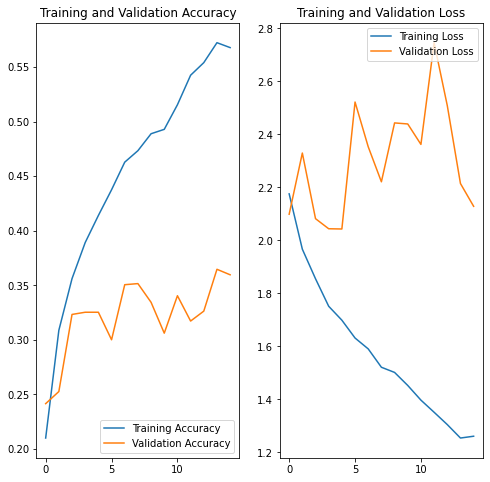

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
predictions = model.predict(val_images, batch_size=32)
print(classification_report(val_labels,
                            predictions.argmax(axis=1),
                            target_names=val_class_names))

              precision    recall  f1-score   support

     Cezanne       0.09      0.06      0.07        99
       Degas       0.11      0.04      0.06        99
     Gauguin       0.10      0.12      0.11        99
      Hassam       0.03      0.01      0.01        99
     Matisse       0.08      0.19      0.11        99
       Monet       0.13      0.12      0.13        99
    Pissarro       0.08      0.06      0.07        99
      Renoir       0.12      0.03      0.05        99
     Sargent       0.09      0.12      0.10        99
     VanGogh       0.14      0.22      0.17        99

    accuracy                           0.10       990
   macro avg       0.10      0.10      0.09       990
weighted avg       0.10      0.10      0.09       990

